##ЯП.Афиши
---
снижение расходов путём отказа от невыгодных источников трафика и перераспределением бюджета

 <u>Содержание:<u>

[ТЗ](#TZ)

[1) Изучаем данные](#load_data)

[2) Метрики](#metrics) 

>[2.1) продуктовые метрики](#metrics_product)

>>[2.1.1) DAU, WAU, MAU](#shaolin)

>>[2.1.2) кол-во заходов в день](#count_ui)

>>[2.1.3) кол-во времени пользователя на сайте](#count_ui_time)

>>[2.1.4) Retention Rate](#Retention_Rate)

>[2.2) Метрики электронной коммерции](#metrics_comerce)

>>[2.2.1) время до первой покупки](#time_buy)

>>[2.2.2) среднее количество покупок на одного покупателя за определённый период](#buy_mean)

>>[2.2.3) средний чек](#chek_mean)

>>[2.2.4) LTV](#LTV)

>[2.3) Маркетинговые метрики](#metrics_marketing)

>>[2.3.1) общая сумма расходов на маркетинг](#marketing_sum)

>>[2.3.2) CAC](#CAC)

>>[2.3.3) ROMI](#ROMI)

[Вывод](#conclusion) 

>[3.1) лучшие источники трафика](#trafic_winner)

>[3.2) выводы по каждым метрикам](#metric_conclusion)
>[3.3) итоги когортного анализа](#cohort_analiz)






#ТЗ<a name="TZ"></a>


цель работы: анализ показателей для снижения расходов путём отказа от невыгодных источников трафика и перераспределением бюджета

Для анализа представлены данные логов о посещении целевого сайта, выгрузка заказов и статистика рекламных расходов с июня 2017 по конец мая 2018 года

задачи:
* определить  клиентские сценарии пользования сервисом
* определить временной сценарий первой покупки на сайте
* определить прибыль от каждого клиента
* определить окупаемость расходов на привлечение клиента


Описание данных

Представлено 3 набора данных:

Файл visits_log.csv хранит лог сервера с информацией о посещениях сайта, 

orders_log.csv — информацию о заказах, 

а costs.csv — информацию о расходах на маркетинг.

Структура **visits_log.csv**

Uid — уникальный идентификатор пользователя,

Device — категория устройства пользователя,

Start Ts — дата и время начала сессии,

End Ts — дата и время окончания сессии,

Source Id — идентификатор источника перехода на сайт.

Структура **orders_log.csv**

Uid — уникальный идентификатор пользователя,

Buy Ts — дата и время заказа,

Revenue — сумма заказа.

Структура **costs.csv**

source_id — идентификатор рекламного источника,

dt — дата проведения рекламной кампании,

costs — расходы на эту кампанию.

# служебные блоки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


## 1) Изучаем данные<a name="load_data"></a>

In [2]:
%%time

try:
  df_visits = pd.read_csv('/datasets/visits_log.csv')
  df_orders = pd.read_csv('/datasets/orders_log.csv')
  df_costs = pd.read_csv('/datasets/costs.csv')
except:
  df_visits = pd.read_csv('https://.../visits_log.csv')
  df_orders = pd.read_csv('https://.../orders_log.csv')
  df_costs = pd.read_csv('https://.../datasets/costs.csv')

CPU times: user 822 ms, sys: 135 ms, total: 957 ms
Wall time: 5.57 s


CPU times: user 710 ms, sys: 109 ms, total: 819 ms
Wall time: 12.5 s

In [3]:
display(df_visits.sample(3))
df_visits.info()

,Device,End Ts,Source Id,Start Ts,Uid
53347,desktop,2017-11-19 13:11:00,2,2017-11-19 12:39:00,8836640233993981187
183829,desktop,2017-07-11 10:26:00,2,2017-07-11 09:13:00,4958077356231235751
125640,touch,2018-02-24 08:35:00,4,2018-02-24 08:35:00,4221084402894005612


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


заменим типы данных в столбцах с датами (из 'object' в 'datetime')

In [4]:
df_visits['End Ts'] = pd.to_datetime(df_visits['End Ts'])
df_visits['Start Ts'] = pd.to_datetime(df_visits['Start Ts'])

In [5]:
df_visits['Device'].unique()

array(['touch', 'desktop'], dtype=object)

уникальные значения устройств- в норме. Нет вылетов и неожиданных или дублирующих значений

в данном случае имеется в виду, что значения поля "Device" имеет только 2 различных значения. Нет значений , начинающихся, например, с большой буквы, что могло бы повлиять на анализ, использующий это поле

In [6]:
display(df_orders.sample(3))
df_orders.info()

,Buy Ts,Revenue,Uid
23857,2017-12-13 16:44:00,3.67,4653337979836796653
42424,2018-03-27 17:30:00,1.16,350234304468787544
6064,2017-08-26 11:00:00,4.03,11421902972503418665


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


заменим тип времени заказа на datatime

In [7]:
df_orders['Buy Ts'] = pd.to_datetime(df_orders['Buy Ts'])

In [8]:
display(df_costs.sample(3))
df_costs.info()

,source_id,dt,costs
177,1,2017-11-25,116.21
295,1,2018-03-23,59.97
594,2,2018-01-18,126.74


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


заменим тип времени заказа на datatime

In [9]:
df_costs['dt'] = pd.to_datetime(df_costs['dt'])

## 2) Метрики<a name="metrics"></a>

In [10]:
df_visits['Start Ts'].min()

Timestamp('2017-06-01 00:01:00')

In [11]:
df_visits['Start Ts'].max()

Timestamp('2018-05-31 23:59:00')

посчитаем служебные столбцы- день, неделя, месяц

In [12]:
df_visits['start_ts_day'] = df_visits['Start Ts'].astype('datetime64[D]')

In [13]:
df_visits['start_ts_month'] = df_visits['Start Ts'].astype('datetime64[M]')

In [14]:
df_visits['start_ts_week'] = df_visits['Start Ts'].dt.week
df_visits['start_ts_year'] = df_visits['Start Ts'].dt.year

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """Entry point for launching an IPython kernel.


In [15]:
df_visits.sample(3)

,Device,End Ts,Source Id,Start Ts,Uid,start_ts_day,start_ts_month,start_ts_week,start_ts_year
45976,desktop,2018-04-09 15:32:00,3,2018-04-09 15:31:00,16276447511040022127,2018-04-09,2018-04-01,15,2018
346924,desktop,2017-06-30 18:08:00,3,2017-06-30 17:36:00,12827202825571589728,2017-06-30,2017-06-01,26,2017
150518,desktop,2017-10-06 17:56:00,5,2017-10-06 17:56:00,7355747708241936452,2017-10-06,2017-10-01,40,2017


получили подготовленные данные для дальнейшей работы. Основные работы будут далее. данные лежат во временном промежутке с 2017-06-01 по 2018-05-31

### 2.1) продуктовые метрики<a name="metrics_product"></a>

#### 2.1.1) DAU, WAU, MAU<a name="shaolin"></a>

In [16]:
DAU = df_visits.groupby('start_ts_day')['Uid'].nunique()
#DAU
DAU_mean = DAU.mean()
#DAU_mean

In [17]:
WAU = df_visits.groupby(['start_ts_year', 'start_ts_week'])['Uid'].nunique()
#WAU
WAU_mean = WAU.mean()

In [18]:
MAU = df_visits.groupby('start_ts_month')['Uid'].nunique()
#MAU
MAU_mean = MAU.mean()

In [19]:
print('средние значения метрик: \n DAU:', round(DAU_mean, 1), '\n WAU:', round(WAU_mean, 1), '\n MAU:', round(MAU_mean, 1))


средние значения метрик: 
 DAU: 908.0 
 WAU: 5716.2 
 MAU: 23228.4


построим вспомогательную функцию для вывода графика (для экономии времени и сил)

In [20]:
def shaolin_graf (df, graf_name):
  df.plot(kind = 'line', grid = True, figsize = (15,8), title = graf_name, )
  plt.show()
  display(df.describe())

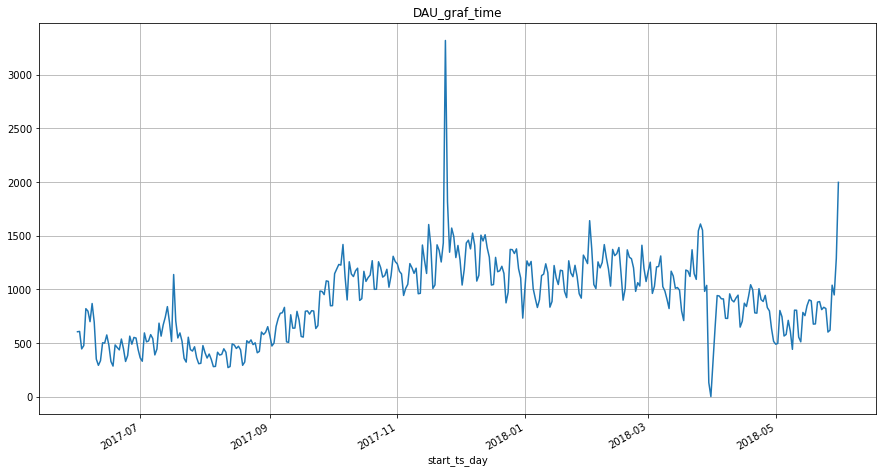

count     364.000000
mean      907.991758
std       370.513838
min         1.000000
25%       594.000000
50%       921.000000
75%      1173.000000
max      3319.000000
Name: Uid, dtype: float64

In [21]:
shaolin_graf(DAU, 'DAU_graf_time')

In [22]:
DAU[DAU == DAU.max()]

start_ts_day
2017-11-24    3319
Name: Uid, dtype: int64

видим, что посещаемость уникальными пользователями начала возрастать с сентября 2017 года. 

24.11.2017 был всплеск посещаемости (в течении одного дня). Мало вероятно, что в это время было грандиозное событие (тогда всплеск был бы более одного дня). Скорее всего, это была автоматизированная накрутка параметра (например, DDOS, или искуственное накручивание кол-ва заходов для получения нужной отчётности)

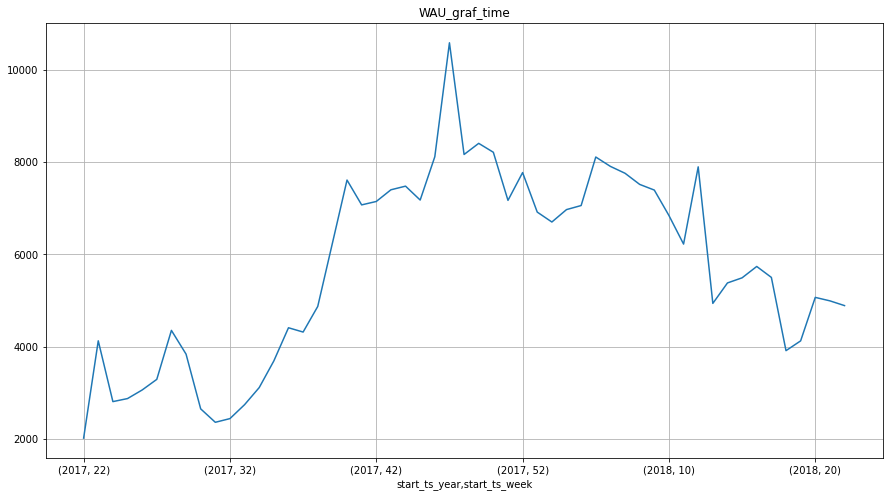

count       53.000000
mean      5716.245283
std       2049.898027
min       2021.000000
25%       4128.000000
50%       5740.000000
75%       7401.000000
max      10586.000000
Name: Uid, dtype: float64

In [23]:
shaolin_graf(WAU, 'WAU_graf_time')

найдём номер недели для даты 24.11.2017:

In [24]:
dww = pd.DataFrame({'col1':['2017-11-24']})
dww['col2'] = dww['col1'].astype('datetime64')
dww['asdasd'] = dww['col2'].dt.week
dww


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,col1,col2,asdasd
0,2017-11-24,2017-11-24,47


как и в прошлом графике видим всплеск на 47 неделе. Видим такое же повышение посещаемости с сентября 2017 года с постепенным понижением с ноября 2018 года

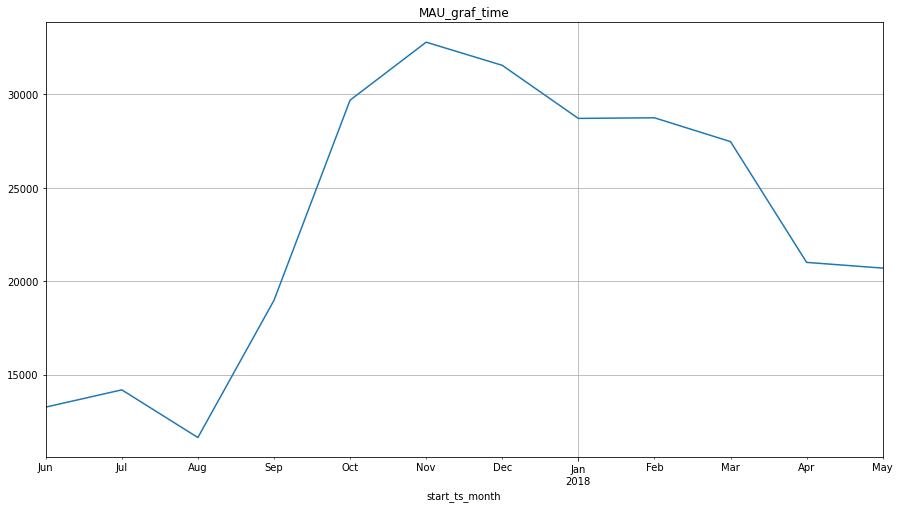

count       12.000000
mean     23228.416667
std       7546.380462
min      11631.000000
25%      17777.000000
50%      24240.500000
75%      28984.750000
max      32797.000000
Name: Uid, dtype: float64

In [25]:
shaolin_graf(MAU, 'MAU_graf_time')

так же, увидели тоже, что и на предыдущи графиках

увидели рост посещаемости с августа 2017 года с выходом на плато в октябре 20117. В марте 2018 пошла на убыль посящаемость. Необходимо разобраться в нововведениях, которые проводились в указанные даты

#### 2.1.2) кол-во заходов в день<a name="count_ui"></a>

посчитаем кол-во заходов в день через общее кол-во заходов и кол-во уникальных заходов в день

In [26]:
coun_ui_per_day = pd.DataFrame(data = df_visits.groupby(['start_ts_day'])['Uid'].count())
coun_ui_per_day.columns = ['count_uid']
coun_ui_per_day.reset_index(inplace = True)

In [27]:
dff1 = pd.DataFrame(data = DAU)
dff1.columns = ['unique_uid']
dff1.reset_index(inplace = True)

In [28]:
coun_ui_per_day = coun_ui_per_day.merge(dff1, on = 'start_ts_day')

In [29]:
coun_ui_per_day['coun_ui_per_day'] = coun_ui_per_day['count_uid'].astype('float') / coun_ui_per_day['unique_uid']

In [30]:
coun_ui_per_day.set_index(coun_ui_per_day['start_ts_day'], inplace = True)

In [31]:
coun_ui_per_day.sample(3)

,start_ts_day,count_uid,unique_uid,coun_ui_per_day
start_ts_day,,,,
2018-02-19,2018-02-19,1490,1368,1.089181
2018-02-09,2018-02-09,1418,1294,1.095827
2017-07-25,2017-07-25,470,439,1.070615


построим график и его параметры

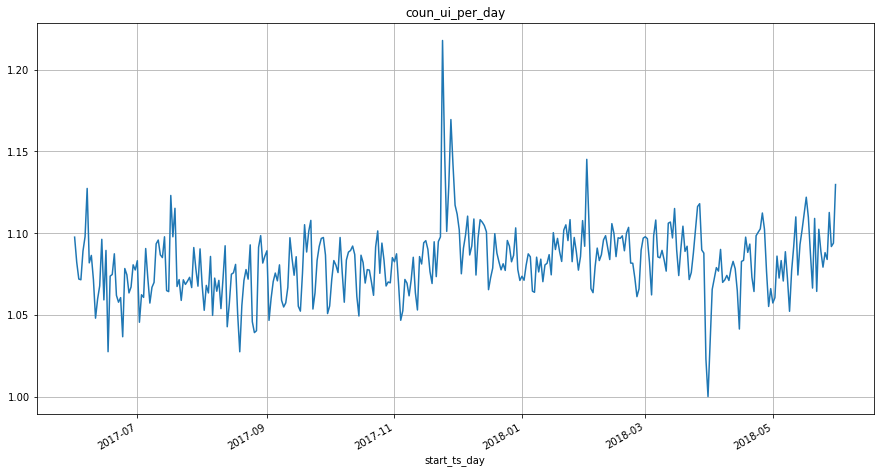

count    364.000000
mean       1.082170
std        0.020876
min        1.000000
25%        1.070321
50%        1.082488
75%        1.093876
max        1.217837
Name: coun_ui_per_day, dtype: float64

In [32]:
shaolin_graf(coun_ui_per_day['coun_ui_per_day'], 'coun_ui_per_day')

In [33]:
coun_ui_per_day[coun_ui_per_day['coun_ui_per_day'] == coun_ui_per_day['coun_ui_per_day'].max()]

,start_ts_day,count_uid,unique_uid,coun_ui_per_day
start_ts_day,,,,
2017-11-24,2017-11-24,4042,3319,1.217837


опять видим всплеск 2017-11-24 - что-то в этот день происходило (исключим вариант неправильно выгруженных данных- уже бы сделали новую выгрузку)

в среднем, пользователь заходит на сайт один раз в день. Соответственно логика продаж должна быть настроена на продажу с первого просмотра. 

#### 2.1.3) кол-во времени пользователя на сайте<a name="count_ui_time"></a>

In [34]:
df_visits['time_session'] = df_visits['End Ts'] - df_visits['Start Ts']
df_visits['time_session'] = df_visits['time_session'].dt.total_seconds()

In [35]:
df_visits.head(5)

,Device,End Ts,Source Id,Start Ts,Uid,start_ts_day,start_ts_month,start_ts_week,start_ts_year,time_session
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-01,51,2017,1080.0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-01,8,2018,1680.0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-07-01,26,2017,0.0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-01,20,2018,1440.0
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017-12-01,52,2017,0.0


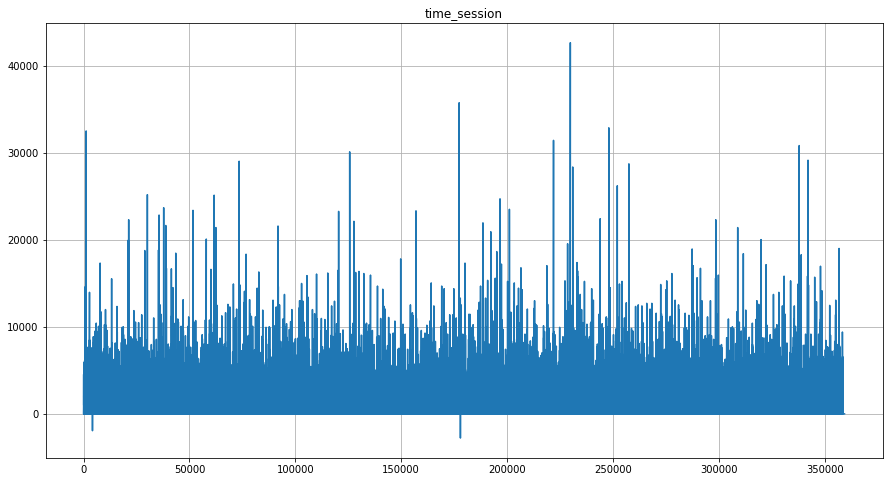

count    359400.000000
mean        643.025687
std         997.127761
min       -2760.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       42660.000000
Name: time_session, dtype: float64

In [36]:
shaolin_graf(df_visits['time_session'], 'time_session')

на первичном графике- видим:

1. ошибки выгрузки (отрицательные значения времени сессии- вероятно, перепутаны даты входа и выхода). Таких значений не много- можно пренебречь

2. нулевые значения- тоже отбросим (вход и сразу выход нам не интересно). Вероятно, это автомаические заходы роботами

3. есть сесии с огромной длительностью (более 2 000 сек) - их тоже отбросим, т.к. их мало и, вероятней всего, пользователь забыл разлогинится (оставил открытую вкладку браузера) и реально не работал с приложением

посмотрим на форму распределения по функции плотности кол-ва времени сессий:

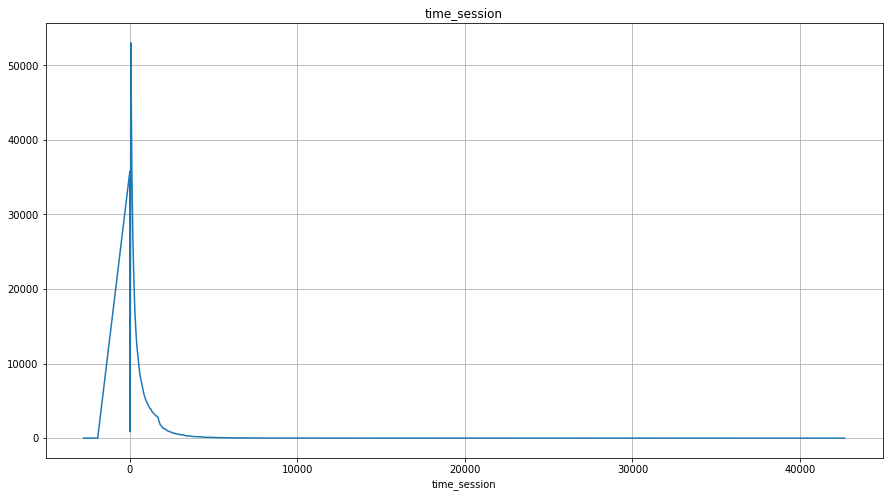

count      312.000000
mean      1151.923077
std       4905.206841
min          1.000000
25%          2.000000
50%          9.000000
75%        114.500000
max      53029.000000
Name: time_session, dtype: float64

In [37]:
shaolin_graf(df_visits.groupby('time_session')['time_session'].count(), 'time_session')

т.к. распределение не является нормальным, а "плохих" значений в общей массе не много, то воспользуемся медианой, как мерой оценки среднего 

In [38]:
print('типичное среднее время пользовательской сессии:', df_visits[ (df_visits['time_session'] > 1) & (df_visits['time_session'] < 2000)  ]['time_session'].median() , 'сек')

типичное среднее время пользовательской сессии: 300.0 сек


среднее время на сайте - 5 мин. Соответственно, пользователь не просматривает много предложений и, зачастую, уже знает что он собирается купить. 5 минут - это поиск уже известного товара и прохождение процедуры покупки, ну и немного, посмотреть другие предложения

#### 2.1.4) Retention Rate<a name="Retention_Rate"></a> 

формировать когорты будем по месяцам (в наличии у нас данные за 1 год). 

т.к. нас в конечном итоге интересует прибыль от приложения- то нам не сильно интересны пустые посещения (не приносящие доход). Поэтому будем использовать данные из таблицы по продажам. "Пустые" посещения интересны для подсчёта конверсии

In [39]:
df_orders['buy_ts_month'] = df_orders['Buy Ts'].astype('datetime64[M]')
#создадимкопию для решения для комментари v1
df_orders_v1 = df_orders.copy()
df_orders_v2 = df_orders.copy()

посчитаем даты первой активности (экономической) пользователей

In [40]:
#df_orders_v2



In [41]:
#посчитаем даты первой активности (экономической) пользователей

first_buy_date_v2 = df_orders_v2.groupby('Uid')['buy_ts_month'].min()
first_buy_date_v2.name = 'first_buy_date'
df_orders_v2 = df_orders_v2.join(first_buy_date_v2, on = 'Uid')



посчитаем новый доп параметр (начало)

In [42]:
first_buy_date_v2 = df_orders_v2.groupby('Uid')['Buy Ts'].min()
first_buy_date_v2.name = 'first_buy_day'
df_orders_v2 = df_orders_v2.join(first_buy_date_v2, on = 'Uid')

In [43]:
df_orders_v2['first_buy_day'] = df_orders_v2['first_buy_day'].dt.day

посчитаем новый доп параметр (конец)

In [44]:
# переведём всё из дат в цифры:
df_orders_v2['buy_year'] = df_orders_v2['buy_ts_month'].dt.year
df_orders_v2['buy_month'] = df_orders_v2['buy_ts_month'].dt.month
df_orders_v2['buy_day'] = df_orders_v2['Buy Ts'].dt.day
df_orders_v2['first_buy_year'] = df_orders_v2['first_buy_date'].dt.year
df_orders_v2['first_buy_month'] = df_orders_v2['first_buy_date'].dt.month



In [45]:
#посчитаем кол-во месяцев с первой покупки для каждого пользователя:

df_orders_v2['cohort_lifetime'] = (( df_orders_v2['buy_year'] - df_orders_v2['first_buy_year'] ) * 12) + (df_orders_v2['buy_month'] - df_orders_v2['first_buy_month'])


посчитаем новый доп параметр (начало)

учтём день покупки для подсчёта полных месяцев- если номер дня покупки больше номера первого дня покупки- то столбец cohort_lifetime посчитан правильно. Если номер дня покупки меньше номера дня первой покупки, то cohort_lifetime посчитан неправильно (он больше на "1" правильного подсчёта, т.е. полный месяц со дня первой покупки ещё не прошёл)

In [46]:
df_orders_v2['cohort_lifetime_popravka'] = df_orders_v2['buy_day'] - df_orders_v2['first_buy_day']
df_orders_v2.loc[ df_orders_v2['cohort_lifetime_popravka'] >=0  ,'cohort_lifetime_popravka'] = 0
df_orders_v2.loc[ df_orders_v2['cohort_lifetime_popravka'] <0  ,'cohort_lifetime_popravka'] = -1
df_orders_v2['cohort_lifetime'] = df_orders_v2['cohort_lifetime']  + df_orders_v2['cohort_lifetime_popravka']


посчитаем новый доп параметр (конец)

In [47]:
#df_orders_v2

In [48]:
# посчитаем кол-во активных пользователей для каждой когорты в каждом месяце:

cohorts_v2 = df_orders_v2.groupby(['first_buy_date','cohort_lifetime'])['Uid'].nunique().reset_index()
cohorts_v2 = cohorts_v2.rename(columns= {'Uid' : 'Uid_nunique'})



In [49]:
# посчитаем изначальное кол-во уникальных пользователей для каждой когорты и сложим в рабосую таблицу:

cohorts_rab_tabke_v2 = cohorts_v2[ cohorts_v2['cohort_lifetime'] == 0 ][['first_buy_date','Uid_nunique']]
cohorts_rab_tabke_v2 = cohorts_rab_tabke_v2.rename(columns= {'Uid_nunique' : 'Uid_nunique_start_cohort'})



In [50]:
#сведём в единую таблицу:

cohorts_v2 = cohorts_v2.merge(cohorts_rab_tabke_v2 , on = 'first_buy_date')



In [51]:
# посчитаем Retention Rate:

cohorts_v2['retention_rate'] = 100 * cohorts_v2['Uid_nunique'] / cohorts_v2['Uid_nunique_start_cohort']



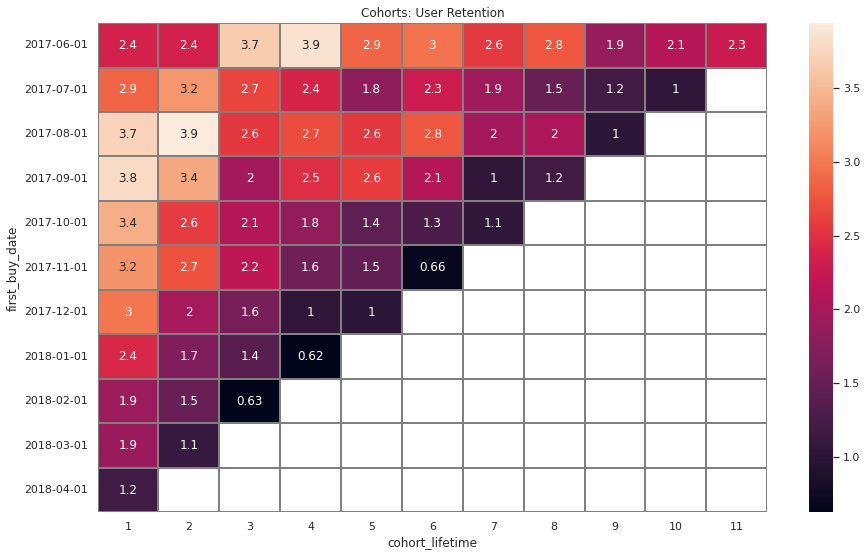

In [52]:
#выведем красивую таблицу:
cohorts_v2['first_buy_date'] = cohorts_v2['first_buy_date'].astype('str')
#cohorts_v2 = cohorts_v2[ cohorts_v2['cohort_lifetime'] != 0  ]

retention_rate_pivot_v2 = cohorts_v2[ cohorts_v2['cohort_lifetime'] != 0  ].pivot_table(
    index='first_buy_date',
    columns='cohort_lifetime',
    values='retention_rate',
    aggfunc='sum',
) 

sns.set(style='white')
plt.figure(figsize=(15, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_rate_pivot_v2, annot=True,  linewidths=1, linecolor='gray'); 

как видим из таблицы- повторную покупку мало кто делает. но, в срднем, стабильное кол-во пользователей остаётся на платформе для последующих покупок

In [53]:
print('средний Retention Rate на второй месяц «жизни» когорт:', round(cohorts_v2[ cohorts_v2['cohort_lifetime'] == 2 ]['retention_rate'].mean() , 1), '%')

средний Retention Rate на второй месяц «жизни» когорт: 2.5 %


параметр конечн падает с течением времени для всех когорт, НО падает не критично, можно сказать что колеблица в районе 2%. Это говорит, что появляется прослойка лояльных покупателей, которые не уходят с платформ. Так же, мы увидели что в последний месяц у "старых" когорт немного (не сильно) увеличился параметр- могу предположить, что прошла какая-то успешная маркетинговая программа для тех, кто уже что-то купил (даи скидку на новую покупку?)

### 2.2) Метрики электронной коммерции<a name="metrics_comerce"></a>

#### 2.2.1) время до первой покупки<a name="time_buy"></a> 

создадим рабочую таблицу

In [54]:
df_visits_rab_table = df_visits.groupby('Uid')['Start Ts'].min()
df_visits_rab_table.name = 'df_visits_rab_table'
df_visits_rab_table = pd.DataFrame(df_visits_rab_table)
df_visits_rab_table.reset_index(inplace= True)
df_visits_rab_table = df_visits_rab_table.rename(columns= {'df_visits_rab_table': 'first_visit'})

In [55]:
df_orders_rab_table = df_orders.groupby('Uid')['Buy Ts'].min()
df_orders_rab_table.name = 'df_orders_rab_table'
df_orders_rab_table = pd.DataFrame(df_orders_rab_table)
df_orders_rab_table.reset_index(inplace= True)
df_orders_rab_table = df_orders_rab_table.rename(columns= {'df_orders_rab_table': 'first_buy'})

In [56]:
df_rab_table_time = df_visits_rab_table.merge (df_orders_rab_table, on = 'Uid')

считаем нужный параметр:

In [57]:
df_rab_table_time['time_first_visit_first_buy'] = (df_rab_table_time['first_buy'] - df_rab_table_time['first_visit']) /  np.timedelta64(1, 'D')



In [58]:
print('времени в среднем проходит с момента первого посещения сайта до совершения покупки:' , round( df_rab_table_time['time_first_visit_first_buy'].mean() , 1), 'дней')

времени в среднем проходит с момента первого посещения сайта до совершения покупки: 16.9 дней


In [59]:
#df_rab_table_time['time_first_visit_first_buy']
df_rab_table_time['time_first_visit_first_buy_count_1'] = round( df_rab_table_time['time_first_visit_first_buy'] , 0)
#df_rab_table_time

In [60]:
#df_rab_table_time.groupby('time_first_visit_first_buy')['time_first_visit_first_buy'].count()

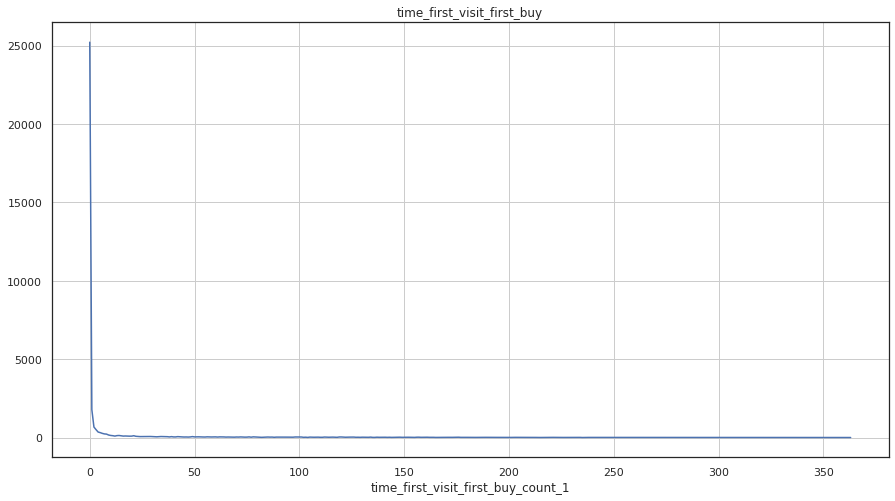

count      348.000000
mean       104.951149
std       1354.545436
min          1.000000
25%          4.000000
50%         12.500000
75%         28.250000
max      25217.000000
Name: time_first_visit_first_buy_count_1, dtype: float64

In [61]:
shaolin_graf(
    df_rab_table_time.groupby('time_first_visit_first_buy_count_1')['time_first_visit_first_buy_count_1'].count()
    , 'time_first_visit_first_buy')

т.к. распределение не является нормальным, а "плохих" значений в общей массе не много, то воспользуемся медианой, как мерой оценки среднего 

In [62]:
#shaolin_graf(   df_rab_table_time['time_first_visit_first_buy']    , 'time_first_visit_first_buy')

In [63]:
print('времени в среднем проходит с момента первого посещения сайта до совершения покупки:' , round( (df_rab_table_time['time_first_visit_first_buy'].median() * 24*60 ) , 4), 'минут')

времени в среднем проходит с момента первого посещения сайта до совершения покупки: 16.0 минут


Время до первой покупки (16 минут) превышает среднее время на сайте ( 10 минут)- вероятно это то время,котороенеобходимо для регистрации на сайте

#### 2.2.2) среднее количество покупок на одного покупателя за определённый период<a name="buy_mean"></a> 



подготовим специальную таблицу и напишем функцию для произвольных дат:

логика работы будет такая: нас интересуют только активные в выбранный период пользователи. Т.е. если пользователь первый раз появился на сайте после начала нашего периода- проигнорируем его. Если последний раз появился до окончания нашего периода- так же проигнорируем его

In [64]:
df_rab_table_buy_mean = df_orders[['Uid','Buy Ts']]
df_rab_table_buy_mean_v1 = df_rab_table_buy_mean.copy() # для работ по комменатриям 1

In [65]:
df_rab_min_date = df_visits.groupby('Uid')['Start Ts'].min()
df_rab_min_date = pd.DataFrame(df_rab_min_date)
df_rab_min_date.reset_index(inplace= True)
df_rab_min_date = df_rab_min_date.rename(columns= {'Start Ts': 'min_date'})

In [66]:
df_rab_max_date = df_visits.groupby('Uid')['Start Ts'].max()
df_rab_max_date = pd.DataFrame(df_rab_max_date)
df_rab_max_date.reset_index(inplace= True)
df_rab_max_date = df_rab_max_date.rename(columns= {'Start Ts': 'max_date'})

In [67]:
df_rab_table_buy_mean = df_rab_table_buy_mean.merge (df_rab_min_date, on = 'Uid')
df_rab_table_buy_mean = df_rab_table_buy_mean.merge (df_rab_max_date, on = 'Uid')

In [68]:
df_rab_table_buy_mean['Buy Ts'] = df_rab_table_buy_mean['Buy Ts'].astype('datetime64[D]')
df_rab_table_buy_mean['min_date'] = df_rab_table_buy_mean['min_date'].astype('datetime64[D]')
df_rab_table_buy_mean['max_date'] = df_rab_table_buy_mean['max_date'].astype('datetime64[D]')

наша рабочая таблица:

In [69]:
df_rab_table_buy_mean.sample(3)

,Uid,Buy Ts,min_date,max_date
8,3644482766749211722,2017-06-01,2017-06-01,2018-05-11
46638,18401744132870849367,2018-04-25,2018-04-25,2018-04-25
295,14528467823744531564,2017-06-01,2017-06-01,2017-06-29


итак, наша функция:


In [70]:
def buy_mean_per_period (start_date, quantity_month ):

  if quantity_month < 1:
    return 'ошибка в ведённых параметрах'

  start_date = pd.to_datetime(start_date)
  last_date = start_date + np.timedelta64(quantity_month, 'M')

  if df_rab_table_buy_mean['max_date'].max() < last_date:
    return 'нет подходящих данных или ошибка в ведённых параметрах'

  df_rab_table_func = df_rab_table_buy_mean[ (df_rab_table_buy_mean['min_date'] < start_date) &  (df_rab_table_buy_mean['max_date'] > last_date)   ] # убираем пользователей, которые не полностью были активны в наш период
  df_rab_table_func = df_rab_table_func[ (df_rab_table_func['Buy Ts'] >= start_date) & (df_rab_table_func['Buy Ts'] <= last_date)   ] #оставляем только те строки, даты покупок которых удовлетворяют периоду
  rez = df_rab_table_func.groupby('Uid')['Uid'].count()
  rez = pd.DataFrame(rez)
  rez = rez.rename(columns= {'Uid': 'uid_count'})
  rezult_mean = round( (  rez['uid_count'].sum() / len(rez)  ) , 2)


  #print(rezult_mean)
  return rezult_mean
  #print(rez)

повыводим результаты расчётов:

In [71]:
buy_mean_per_period ('2017-07-24', 1)

2.08

In [72]:
buy_mean_per_period ('2017-07-24', 2)

2.38

In [73]:
buy_mean_per_period ('2017-07-24', 4)

2.94

In [74]:
buy_mean_per_period ('2017-07-24', 6)

3.89

Упростим логику расчётов: посчитаем не пологики описанной выше, а по иной логике: будем считать все покупки в периоде. Вводить когорты не будем- т.к. в конечном итоге всё-равно усредняем и получаем одно значение

In [75]:
df_rab_table_buy_mean_v1['buy_ts_day'] = df_rab_table_buy_mean_v1['Buy Ts'].astype('datetime64[D]')
df_rab_table_buy_mean_v1   # наша рабочая таблица

,Uid,Buy Ts,buy_ts_day
0,10329302124590727494,2017-06-01 00:10:00,2017-06-01
1,11627257723692907447,2017-06-01 00:25:00,2017-06-01
2,17903680561304213844,2017-06-01 00:27:00,2017-06-01
3,16109239769442553005,2017-06-01 00:29:00,2017-06-01
4,14200605875248379450,2017-06-01 07:58:00,2017-06-01
...,...,...,...
50410,12296626599487328624,2018-05-31 23:50:00,2018-05-31
50411,11369640365507475976,2018-05-31 23:50:00,2018-05-31
50412,1786462140797698849,2018-05-31 23:54:00,2018-05-31
50413,3993697860786194247,2018-05-31 23:56:00,2018-05-31


построим функцию для подсчёта среднего числа покупателей от даты начала и кол-ва месяцев

In [76]:
def buy_mean_per_period_v1 (start_date, quantity_month ):

  if quantity_month < 1:
    return 'ошибка в ведённых параметрах'

  start_date = pd.to_datetime(start_date)
  last_date = start_date + np.timedelta64(quantity_month, 'M')



  df_rab_table_func = df_rab_table_buy_mean_v1[ (df_rab_table_buy_mean_v1['buy_ts_day'] >= start_date) & (df_rab_table_buy_mean_v1['buy_ts_day'] <= last_date)   ] #оставляем только те строки, даты покупок которых удовлетворяют периоду
  rez = df_rab_table_func.groupby('Uid')['Uid'].count()
  rez = pd.DataFrame(rez)
  rez = rez.rename(columns= {'Uid': 'uid_count'})
  rezult_mean = round( (  rez['uid_count'].sum() / len(rez)  ) , 2)


  #print(rezult_mean)
  return rezult_mean
  #print(rez)

найдём дату начала данных:

In [77]:
df_rab_table_buy_mean_v1['buy_ts_day'].min()

Timestamp('2017-06-01 00:00:00')

In [78]:
buy_mean_per_period_v1('2017-06-01' , 1)

1.16

In [79]:
buy_mean_per_period_v1('2017-06-01' , 3)

1.23

In [80]:
buy_mean_per_period_v1('2017-06-01' , 5)

1.27

In [81]:
buy_mean_per_period_v1('2017-06-01' , 6)

1.3

In [82]:
buy_mean_per_period_v1('2017-06-01' , 10)

1.37

In [83]:
buy_mean_per_period_v1('2017-06-01' , 12)

1.38

как видим из результатов построенной функции- за 1 год кол-во покупок у каждого экономически активного пользователя ассимптотически приближается к 1,4 покупки на человека. Но в общем случае возвращаются за повторной покупкой меньше половины. На данном этапе платформа видится покупателем как платформа "одной покупки" (одна из многих или случайная платформа)

#### 2.2.3) средний чек<a name="chek_mean"></a> 



In [84]:
df_orders['buy_ts_day'] = df_orders['Buy Ts'].astype('datetime64[D]')

средний чек посчитаем следующим образом: посчитаем сумму по дням всех покупок и кол-во уникальных пользователей. разделим одно на другое и найдём среднее

In [85]:
df_mean_chek = df_orders.groupby('buy_ts_day')['Revenue'].sum()
df_mean_chek = pd.DataFrame(df_mean_chek)
df_mean_chek.reset_index(inplace= True)


In [86]:
df_rab_table_nunique_uid = df_orders.groupby('buy_ts_day')['Uid'].nunique()
df_rab_table_nunique_uid = pd.DataFrame(df_rab_table_nunique_uid)
df_rab_table_nunique_uid.reset_index(inplace= True)

In [87]:
df_mean_chek = df_mean_chek.merge(df_rab_table_nunique_uid, on= 'buy_ts_day')

In [88]:
df_mean_chek['mean_chek'] = df_mean_chek['Revenue'] / df_mean_chek['Uid']

In [89]:
print('средний чек:', round(df_mean_chek['mean_chek'].mean() , 2))


средний чек: 5.33


In [90]:
df_mean_chek.index = df_mean_chek['buy_ts_day']
df_mean_chek

,buy_ts_day,Revenue,Uid,mean_chek
buy_ts_day,,,,
2017-06-01,2017-06-01,389.46,86,4.528605
2017-06-02,2017-06-02,324.11,101,3.209010
2017-06-03,2017-06-03,166.48,61,2.729180
2017-06-04,2017-06-04,195.21,59,3.308644
2017-06-05,2017-06-05,441.49,146,3.023904
...,...,...,...,...
2018-05-28,2018-05-28,740.00,178,4.157303
2018-05-29,2018-05-29,491.06,174,2.822184
2018-05-30,2018-05-30,1021.69,189,5.405767


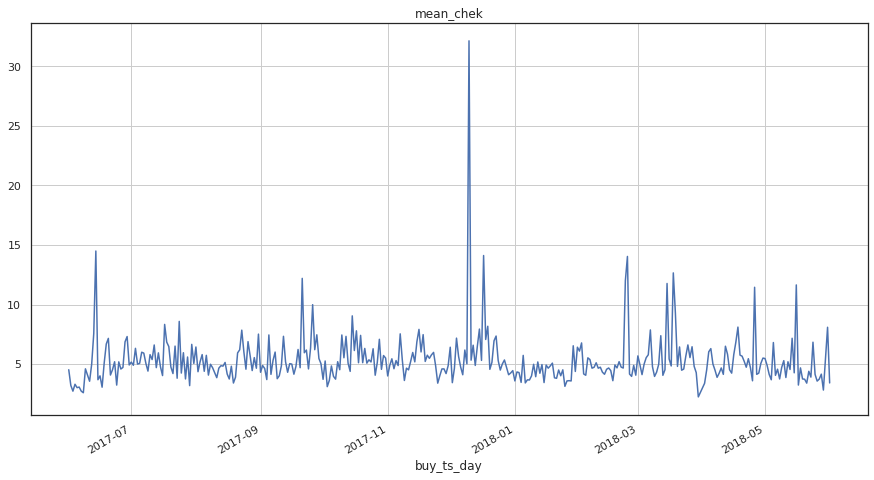

count    364.000000
mean       5.330931
std        2.223256
min        2.247692
25%        4.227089
50%        4.886094
75%        5.796437
max       32.147103
Name: mean_chek, dtype: float64

In [91]:
shaolin_graf(df_mean_chek['mean_chek'], 'mean_chek')

In [92]:
df_mean_chek[ df_mean_chek['mean_chek'] == df_mean_chek['mean_chek'].max()  ]

,buy_ts_day,Revenue,Uid,mean_chek
buy_ts_day,,,,
2017-12-10,2017-12-10,4661.33,145,32.147103


2017-12-10 был огромный всплеск среднего чека. Что-то было в это время

возможно предновогодний всплеск- было какое-то интересное НГ шоу (возможно в этот день были скидки или все билеты раскупили за один день)

#### 2.2.4) LTV<a name="LTV"></a> 



In [93]:
df_orders = df_orders_v2.copy()

добавим точную дату первой покупки (для дальнейшего выбора интервала покупок в 6 месяцев)

In [94]:
first_buy_date_day = df_orders.groupby('Uid')['Buy Ts'].min()
first_buy_date_day.name = 'first_buy_date_day'
df_orders = df_orders.join(first_buy_date_day, on = 'Uid')

отсеим строки с когортами, время жизни которых менее 6 месяцев:

In [95]:
df_orders['first_buy_date'].max()

Timestamp('2018-06-01 00:00:00')

таки образом, нас интересуют, в рамках этой задачи, только покупатели, которые пришли раньше декабря 2017. создадим таблицу с такими пользователями:

In [96]:
df_LTV = df_orders[ df_orders['first_buy_date'] <= pd.to_datetime('2017-12-01' ) ]
df_LTV

,Buy Ts,Revenue,Uid,buy_ts_month,first_buy_date,first_buy_day,buy_year,buy_month,buy_day,first_buy_year,first_buy_month,cohort_lifetime,cohort_lifetime_popravka,first_buy_date_day
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,1,2017,6,1,2017,6,0,0,2017-06-01 00:10:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,1,2017,6,1,2017,6,0,0,2017-06-01 00:25:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,1,2017,6,1,2017,6,0,0,2017-06-01 00:27:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,1,2017,6,1,2017,6,0,0,2017-06-01 00:29:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,1,2017,6,1,2017,6,0,0,2017-06-01 07:58:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50316,2018-05-31 19:04:00,2.32,14878515827023657269,2018-05-01,2017-12-01,18,2018,5,31,2017,12,5,0,2017-12-18 13:59:00
50367,2018-05-31 21:31:00,73.33,11962306486176658682,2018-05-01,2017-08-01,28,2018,5,31,2017,8,9,0,2017-08-28 18:46:00
50375,2018-05-31 21:57:00,2.75,10308683708945899048,2018-05-01,2017-06-01,15,2018,5,31,2017,6,11,0,2017-06-15 11:07:00
50380,2018-05-31 22:11:00,2.10,16406946519013896708,2018-05-01,2017-12-01,18,2018,5,31,2017,12,5,0,2017-12-18 10:19:00


Так же, по условию покупок нас интересует период закупок в 6 месяцев. Оставим только такие записи

In [97]:
df_LTV = df_LTV[ df_LTV['Buy Ts'] <= (df_LTV['first_buy_date_day'] + np.timedelta64(6, 'M')) ]
df_LTV
                                                          

,Buy Ts,Revenue,Uid,buy_ts_month,first_buy_date,first_buy_day,buy_year,buy_month,buy_day,first_buy_year,first_buy_month,cohort_lifetime,cohort_lifetime_popravka,first_buy_date_day
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,1,2017,6,1,2017,6,0,0,2017-06-01 00:10:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,1,2017,6,1,2017,6,0,0,2017-06-01 00:25:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,1,2017,6,1,2017,6,0,0,2017-06-01 00:27:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,1,2017,6,1,2017,6,0,0,2017-06-01 00:29:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,1,2017,6,1,2017,6,0,0,2017-06-01 07:58:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50184,2018-05-31 15:06:00,2.32,2347028803786630930,2018-05-01,2017-12-01,11,2018,5,31,2017,12,5,0,2017-12-11 13:47:00
50212,2018-05-31 15:59:00,9.78,7429541316924164556,2018-05-01,2017-12-01,8,2018,5,31,2017,12,5,0,2017-12-08 17:42:00
50280,2018-05-31 17:43:00,0.61,10335482478740494849,2018-05-01,2017-12-01,15,2018,5,31,2017,12,5,0,2017-12-15 16:47:00
50316,2018-05-31 19:04:00,2.32,14878515827023657269,2018-05-01,2017-12-01,18,2018,5,31,2017,12,5,0,2017-12-18 13:59:00


т.к. маржинальность равна 1,00, то править столбец "Revenue" не будем. Начианаем считать среднее LTV по когортам:

In [98]:
LTV_sum = df_LTV.groupby('first_buy_date')['Revenue'].sum()
LTV_sum = pd.DataFrame(LTV_sum)
LTV_sum.reset_index(inplace= True)
LTV_sum

,first_buy_date,Revenue
0,2017-06-01,17663.04
1,2017-07-01,14775.48
2,2017-08-01,10353.16
3,2017-09-01,32839.51
4,2017-10-01,26831.65
5,2017-11-01,25832.99
6,2017-12-01,33485.74


In [99]:
LTV_nunique = df_LTV.groupby('first_buy_date')['Uid'].nunique()
LTV_nunique = pd.DataFrame(LTV_nunique)
LTV_nunique.reset_index(inplace= True)
LTV_nunique

,first_buy_date,Uid
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340
5,2017-11-01,4081
6,2017-12-01,4383


In [100]:
LTV = LTV_sum.merge(LTV_nunique, on = 'first_buy_date')
LTV['LTV'] = LTV['Revenue'] / LTV['Uid']
print('распределени LTV за 6 месяцев по когортам: \n', LTV[['first_buy_date','LTV']] )
#LTV

распределени LTV за 6 месяцев по когортам: 
   first_buy_date        LTV
0     2017-06-01   8.731112
1     2017-07-01   7.683557
2     2017-08-01   7.557051
3     2017-09-01  12.723561
4     2017-10-01   6.182408
5     2017-11-01   6.330064
6     2017-12-01   7.639913


средний LTV за 6 месяцев:

In [101]:
print('средний LTV за 6 месяцев: ' , 
     round(LTV['Revenue'].sum() / LTV['Uid'].sum() ,2  ))

средний LTV за 6 месяцев:  7.82


In [102]:
#LTV

In [103]:
LTV.index = LTV['first_buy_date']

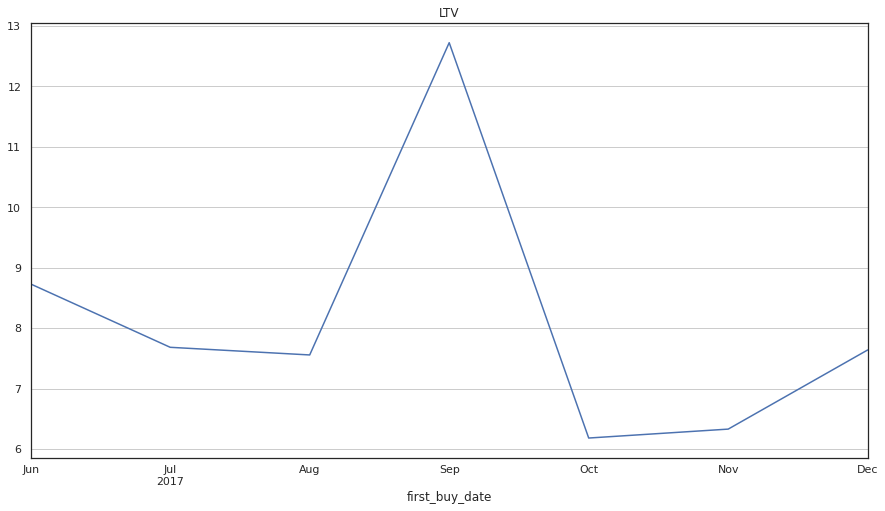

count     7.000000
mean      8.121095
std       2.208402
min       6.182408
25%       6.943557
50%       7.639913
75%       8.207335
max      12.723561
Name: LTV, dtype: float64

In [104]:
shaolin_graf(LTV['LTV'], 'LTV')

из выходных данных видно, что есть всплеск для когорты 3 (сентябрь 2017 года)

In [105]:
df_LTV_v1 = df_orders_v2

получим нашу раб таблицу:

In [106]:
LTV_v1 = df_LTV_v1.groupby(['first_buy_date','cohort_lifetime']).agg({'Revenue':'sum' }).groupby(level=[0]).cumsum().reset_index()

#LTV_v1.head(16)

In [107]:
LTV_v1_nunique = df_LTV_v1.groupby(['first_buy_date'])['Uid'].nunique().reset_index()
#LTV_v1_nunique

In [108]:
LTV_v1 = LTV_v1.merge(LTV_v1_nunique , on= 'first_buy_date')
LTV_v1['LTV'] = LTV_v1['Revenue'] / LTV_v1['Uid']

#LTV_v1.head(25)

In [109]:
# выведем красивую таблицу:
LTV_v1['first_buy_date'] = LTV_v1['first_buy_date'].astype('str')

retention_rate_LTV_v1 = LTV_v1.pivot_table(
    index='first_buy_date',
    columns='cohort_lifetime',
    values='LTV',
    #aggfunc='cumsum',
) 
#retention_rate_LTV_v1

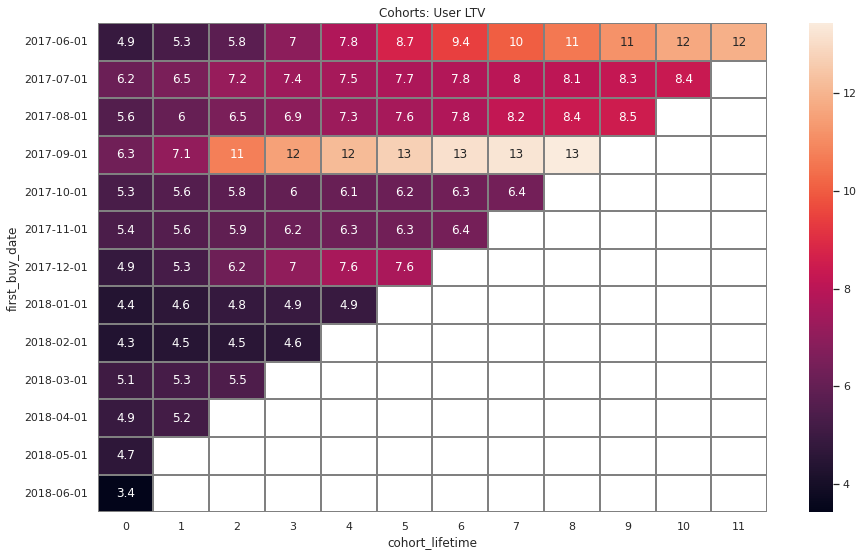

In [110]:
sns.set(style='white')
plt.figure(figsize=(15, 9))
plt.title('Cohorts: User LTV')
sns.heatmap(retention_rate_LTV_v1, annot=True,  linewidths=1, linecolor='gray'); 

получили визуализацию кумулятивной характеристики. Видим нерастущие когорты (например, 2018-01-01). Так же, наблюдаем, что старые когорты одни из самых прибыльных

### 2.3) Маркетинговые метрики<a name="metrics_marketing"></a>


#### 2.3.1) общая сумма расходов на маркетинг<a name="marketing_sum"></a> 



In [111]:
df_costs.sample(3)

,source_id,dt,costs
1401,4,2018-04-11,161.69
1128,4,2017-07-10,59.37
1363,4,2018-03-02,40.49


In [112]:
print('общая сумма затрат на рекламу:', round ( df_costs['costs'].sum() ,1))

общая сумма затрат на рекламу: 329131.6


In [113]:
print('общая сумма затрат на рекламу:', round ( df_costs['costs'].sum() ,1) , 'у.е.')

общая сумма затрат на рекламу: 329131.6 у.е.


In [114]:
print('распределение трат по источникам: \n', df_costs.groupby('source_id')['costs'].sum()  )

распределение трат по источникам: 
 source_id
1      20833.27
2      42806.04
3     141321.63
4      61073.60
5      51757.10
9       5517.49
10      5822.49
Name: costs, dtype: float64


построим график изменения сумы трат на маркетинг от даты:


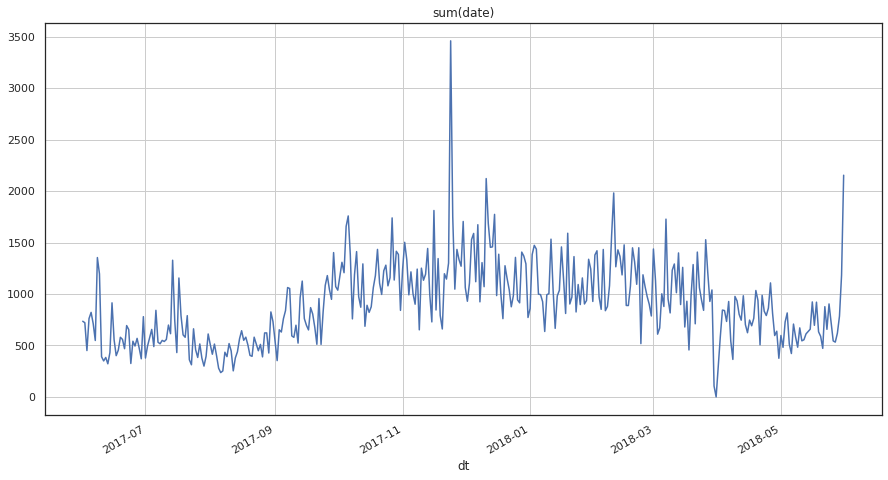

count     364.000000
mean      904.207747
std       396.956825
min         0.700000
25%       595.682500
50%       873.655000
75%      1155.605000
max      3458.860000
Name: costs, dtype: float64

In [115]:
shaolin_graf(df_costs.groupby('dt')['costs'].sum(), 'sum(date)')


sum(date) - это название функции, которая построена на графики, т.е. зависимость суммы трат на маркетинг на конкретный день от этой даты. Аналогия - y(x)



In [116]:
df_costs.groupby('dt')['costs'].sum()[ df_costs.groupby('dt')['costs'].sum() == df_costs.groupby('dt')['costs'].sum().max() ]

dt
2017-11-24    3458.86
Name: costs, dtype: float64

опять видим магическую дату 2017-11-24. Сдесь был всплеск маркетинговых трат (а не накрутка захдов это была?). Или вложения в маркетинг в эту дату дали такой всплеск посещаемости и покупок? Тогда что это за вложение такое было?

In [117]:
df_costs

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
...,...,...,...
2537,10,2018-05-27,9.92
2538,10,2018-05-28,21.26
2539,10,2018-05-29,11.32
2540,10,2018-05-30,33.15


In [118]:
#  shaolin_graf(df_costs.groupby('dt')['costs'].sum(), 'sum(date)')

In [119]:
df_costs_v1 = df_costs

In [120]:
df_costs_v1_pivot_table = df_costs_v1.pivot_table(
    index = 'dt'
    , columns = 'source_id'
    , values = 'costs'
    , aggfunc = 'sum'

)
#df_costs_v1_pivot_table

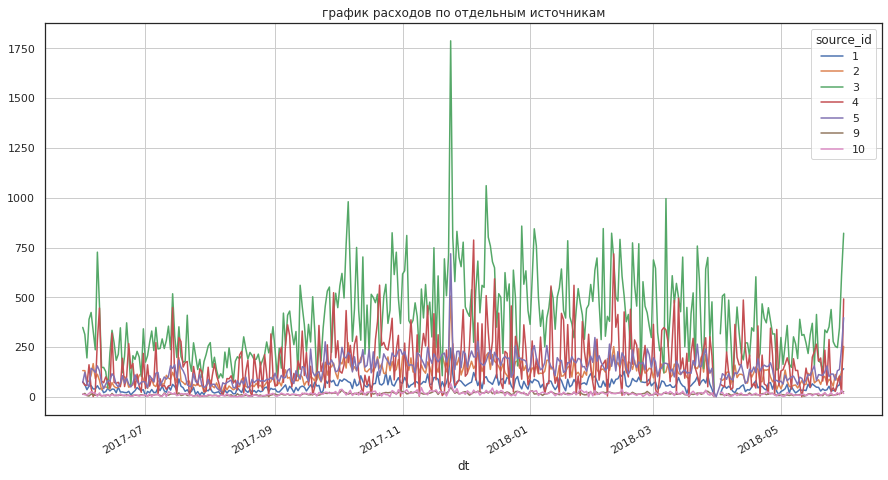

source_id,1,2,3,4,5,9,10
count,363.000000,363.000000,363.000000,363.000000,364.000000,363.000000,363.000000
mean,57.391928,117.922975,389.315785,168.246832,142.189835,15.199697,16.039917
std,27.813968,53.971467,209.480437,137.033287,65.289628,6.829491,9.440731
min,5.800000,15.080000,39.260000,0.830000,0.700000,1.850000,0.540000
25%,36.250000,77.855000,226.480000,59.515000,92.497500,9.795000,9.150000
50%,54.710000,115.970000,353.140000,130.070000,137.300000,14.490000,14.670000
75%,75.630000,149.160000,504.045000,254.385000,180.350000,19.975000,21.495000
max,245.750000,507.090000,1788.280000,788.030000,719.220000,49.530000,68.110000


In [121]:
shaolin_graf(df_costs_v1_pivot_table, 'график расходов по отдельным источникам')

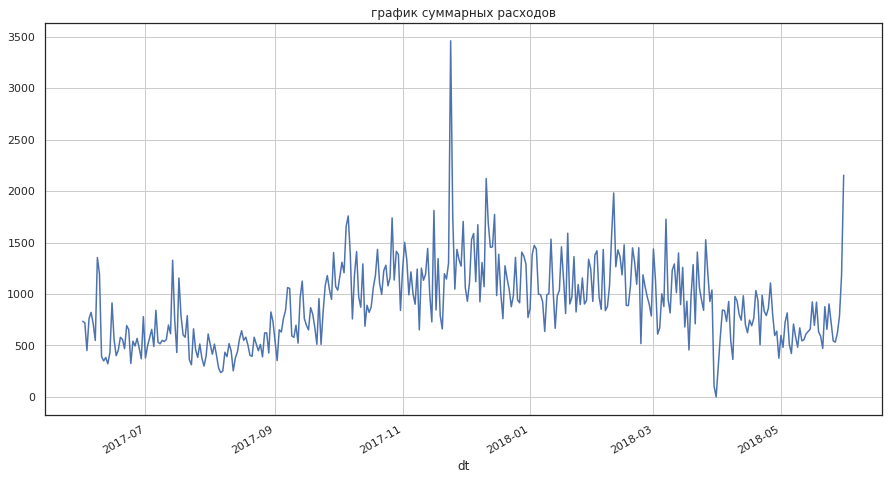

count     364.000000
mean      904.207747
std       396.956825
min         0.700000
25%       595.682500
50%       873.655000
75%      1155.605000
max      3458.860000
Name: costs, dtype: float64

In [122]:
shaolin_graf(df_costs.groupby('dt')['costs'].sum(), 'график суммарных расходов')

из приведённых графиков суммарных расходов и расходов по каждому источнику видим что динамика совпадает. Видим, что больший вклад в суммарный расход вносит 3 источник, соответственно динамика суммарного расхода будет тяготеть к динамике источника № 3. Источник  № 10 почти не финансировался


#### 2.3.2) CAC<a name="CAC"></a> 




In [123]:
df_costs['source_id'].unique()

array([ 1,  2,  3,  4,  5,  9, 10])

интересно- идентификаторы рекламы идут не подряд- судя по всему- была реклама, на которую не тратили деньги (в отчётном периоде)

In [124]:
print('средний CAC на одного покупателя для всего проекта:', round(df_costs['costs'].sum() / df_orders['Uid'].nunique() , 2) )

средний CAC на одного покупателя для всего проекта: 9.01


посчитаем сводную таблицу для расчёта САС по путям прихода:

In [125]:
df_CAC = df_orders.merge(df_visits, how = 'inner', on='Uid')
df_CAC = df_CAC[['Uid' , 'Source Id' , 'Revenue' , 'Buy Ts' , 'Start Ts' , 'End Ts']]
df_CAC

,Uid,Source Id,Revenue,Buy Ts,Start Ts,End Ts
0,10329302124590727494,1,17.00,2017-06-01 00:10:00,2017-06-01 00:09:00,2017-06-01 00:11:00
1,11627257723692907447,2,0.55,2017-06-01 00:25:00,2017-06-01 00:14:00,2017-06-01 00:25:00
2,17903680561304213844,2,0.37,2017-06-01 00:27:00,2017-06-01 00:25:00,2017-06-01 00:34:00
3,16109239769442553005,2,0.55,2017-06-01 00:29:00,2017-06-01 00:14:00,2017-06-01 00:33:00
4,14200605875248379450,3,0.37,2017-06-01 07:58:00,2017-06-01 07:31:00,2017-06-01 07:59:00
...,...,...,...,...,...,...
761802,3993697860786194247,4,3.67,2018-05-31 23:56:00,2018-01-15 10:39:00,2018-01-15 10:47:00
761803,3993697860786194247,5,3.67,2018-05-31 23:56:00,2017-12-12 16:20:00,2017-12-12 16:21:00
761804,3993697860786194247,3,3.67,2018-05-31 23:56:00,2017-10-23 12:32:00,2017-10-23 12:36:00
761805,3993697860786194247,4,3.67,2018-05-31 23:56:00,2017-11-15 17:08:00,2017-11-15 17:18:00


т.к. при соединении таблиц некоторые результаты заможились- избавимся от них по следующей логике: df_CAC['Buy Ts'] <= df_CAC['End Ts'] ) & (df_CAC['Buy Ts'] >= df_CAC['Start Ts']) , т.е. реальная строка - эта та строка, где время покупки лежит в интервале между началом сессии и её окончанием (считаем, что автоматических покупок у нас нет, соответственно, для покупки необходимо зайти на сайт (начать сессию))

In [126]:
df_CAC = df_CAC[ (df_CAC['Buy Ts'] <= df_CAC['End Ts'] ) & (df_CAC['Buy Ts'] >= df_CAC['Start Ts']) ]
df_CAC

,Uid,Source Id,Revenue,Buy Ts,Start Ts,End Ts
0,10329302124590727494,1,17.00,2017-06-01 00:10:00,2017-06-01 00:09:00,2017-06-01 00:11:00
1,11627257723692907447,2,0.55,2017-06-01 00:25:00,2017-06-01 00:14:00,2017-06-01 00:25:00
2,17903680561304213844,2,0.37,2017-06-01 00:27:00,2017-06-01 00:25:00,2017-06-01 00:34:00
3,16109239769442553005,2,0.55,2017-06-01 00:29:00,2017-06-01 00:14:00,2017-06-01 00:33:00
4,14200605875248379450,3,0.37,2017-06-01 07:58:00,2017-06-01 07:31:00,2017-06-01 07:59:00
...,...,...,...,...,...,...
761790,15854392578508828030,4,0.92,2018-05-31 23:42:00,2018-05-31 23:26:00,2018-05-31 23:47:00
761798,12296626599487328624,4,4.64,2018-05-31 23:50:00,2018-05-31 23:46:00,2018-06-01 00:13:00
761800,11369640365507475976,10,5.80,2018-05-31 23:50:00,2018-05-31 23:05:00,2018-05-31 23:55:00
761801,1786462140797698849,3,0.30,2018-05-31 23:54:00,2018-05-31 23:52:00,2018-05-31 23:55:00


увидели интересный результат: в изначальной таблице orders- 50,4 тыс. строк, в промежуточной таблице df_CAC - 36 тыс строк - т.е. были залогированы покупки и в тоже время лог посещения не вёлся. Ошибка в выгрузке данных? Будем работать только с "хорошими" данными


теперь присоеденим таблицу по маркетингу для поиска стоимости маркетинговых компаний:

In [127]:
df_CAC = df_CAC.rename({'Source Id' : 'source_id'}, axis=1)

In [128]:

df_CAC = df_CAC.merge(df_costs , on = 'source_id')
df_CAC

,Uid,source_id,Revenue,Buy Ts,Start Ts,End Ts,dt,costs
0,10329302124590727494,1,17.0,2017-06-01 00:10:00,2017-06-01 00:09:00,2017-06-01 00:11:00,2017-06-01,75.20
1,10329302124590727494,1,17.0,2017-06-01 00:10:00,2017-06-01 00:09:00,2017-06-01 00:11:00,2017-06-02,62.25
2,10329302124590727494,1,17.0,2017-06-01 00:10:00,2017-06-01 00:09:00,2017-06-01 00:11:00,2017-06-03,36.53
3,10329302124590727494,1,17.0,2017-06-01 00:10:00,2017-06-01 00:09:00,2017-06-01 00:11:00,2017-06-04,55.00
4,10329302124590727494,1,17.0,2017-06-01 00:10:00,2017-06-01 00:09:00,2017-06-01 00:11:00,2017-06-05,57.08
...,...,...,...,...,...,...,...,...
13048557,11369640365507475976,10,5.8,2018-05-31 23:50:00,2018-05-31 23:05:00,2018-05-31 23:55:00,2018-05-27,9.92
13048558,11369640365507475976,10,5.8,2018-05-31 23:50:00,2018-05-31 23:05:00,2018-05-31 23:55:00,2018-05-28,21.26
13048559,11369640365507475976,10,5.8,2018-05-31 23:50:00,2018-05-31 23:05:00,2018-05-31 23:55:00,2018-05-29,11.32
13048560,11369640365507475976,10,5.8,2018-05-31 23:50:00,2018-05-31 23:05:00,2018-05-31 23:55:00,2018-05-30,33.15


опять получили замножение строк- избавимся от них по аноологии с прошлым разом:дата покупки должна совпадать с датой проведения акции

In [129]:
df_CAC = df_CAC [ df_CAC['Buy Ts'].astype('datetime64[D]') == df_CAC['dt'].astype('datetime64[D]')]
df_CAC

,Uid,source_id,Revenue,Buy Ts,Start Ts,End Ts,dt,costs
0,10329302124590727494,1,17.00,2017-06-01 00:10:00,2017-06-01 00:09:00,2017-06-01 00:11:00,2017-06-01,75.20
363,3644482766749211722,1,1.22,2017-06-01 09:22:00,2017-06-01 09:22:00,2017-06-01 09:22:19,2017-06-01,75.20
768,3644482766749211722,1,3.67,2017-07-13 14:40:00,2017-07-13 14:40:00,2017-07-13 14:40:00,2017-07-13,34.52
1180,3644482766749211722,1,1.83,2017-08-31 14:21:00,2017-08-31 14:19:00,2017-08-31 14:28:00,2017-08-31,38.26
1548,3644482766749211722,1,0.49,2017-09-05 15:52:00,2017-09-05 15:41:00,2017-09-05 16:03:00,2017-09-05,48.53
...,...,...,...,...,...,...,...,...
13047109,5291123048634376500,10,6.23,2018-05-31 21:22:00,2018-05-31 21:12:00,2018-05-31 21:29:00,2018-05-31,17.60
13047472,17262220372192361159,10,7.33,2018-05-31 21:54:00,2018-05-31 21:46:00,2018-05-31 22:08:00,2018-05-31,17.60
13047835,15116668155510764243,10,2.44,2018-05-31 22:50:00,2018-05-31 22:47:00,2018-05-31 22:51:00,2018-05-31,17.60
13048198,15576344609395725707,10,2.26,2018-05-31 23:40:00,2018-05-31 23:35:00,2018-05-31 23:44:00,2018-05-31,17.60


кол-во строк до и после преобразования сошлось- УРА!!!

теперь поудаляем лишние столбцы:


In [130]:
df_CAC = df_CAC[['Uid' , 'source_id' , 'costs' , 'Buy Ts' , 'Revenue' ]].reset_index(drop = True)
df_CAC

,Uid,source_id,costs,Buy Ts,Revenue
0,10329302124590727494,1,75.20,2017-06-01 00:10:00,17.00
1,3644482766749211722,1,75.20,2017-06-01 09:22:00,1.22
2,3644482766749211722,1,34.52,2017-07-13 14:40:00,3.67
3,3644482766749211722,1,38.26,2017-08-31 14:21:00,1.83
4,3644482766749211722,1,48.53,2017-09-05 15:52:00,0.49
...,...,...,...,...,...
35920,5291123048634376500,10,17.60,2018-05-31 21:22:00,6.23
35921,17262220372192361159,10,17.60,2018-05-31 21:54:00,7.33
35922,15116668155510764243,10,17.60,2018-05-31 22:50:00,2.44
35923,15576344609395725707,10,17.60,2018-05-31 23:40:00,2.26


теперь будем считать средний САС для всего проекта (за 1 год) по источникам прихода:

In [131]:
CAC_sum = df_CAC.groupby('source_id')['costs'].sum()
CAC_sum = pd.DataFrame(CAC_sum)
CAC_sum.reset_index(inplace= True)
#CAC_sum

In [132]:
CAC_nunique = df_CAC.groupby('source_id')['Uid'].nunique()
CAC_nunique = pd.DataFrame(CAC_nunique)
CAC_nunique.reset_index(inplace= True)
#CAC_nunique

In [133]:
CAC = CAC_sum.merge(CAC_nunique, on= 'source_id')
CAC['CAC'] = CAC['costs'] / CAC['Uid']
print('CAC в зависимости от источника прихода: \n' , CAC[['source_id','CAC']])
#CAC

CAC в зависимости от источника прихода: 
    source_id         CAC
0          1   86.077126
1          2  185.650479
2          3  479.944121
3          4  200.879795
4          5  184.190799
5          9   21.409571
6         10   20.021381


далее построим графики для каждого источника прихода САС(дата)

Создадим вспомогательную таблицу:

In [134]:
df_CAC2=df_CAC
df_CAC2['Buy Ts'] = df_CAC2['Buy Ts'].astype('datetime64[D]')

In [135]:
CAC2 = df_CAC2.groupby(['Buy Ts', 'source_id']).agg({'costs':'sum', 'Uid':'nunique'}).reset_index()
CAC2['CAC'] = CAC2['costs'] / CAC2['Uid']
#CAC2

In [136]:
dfff = CAC2.pivot_table(
    index = 'Buy Ts',
    columns='source_id',
    values='CAC',
    #aggfunc='mean',
)
#dfff

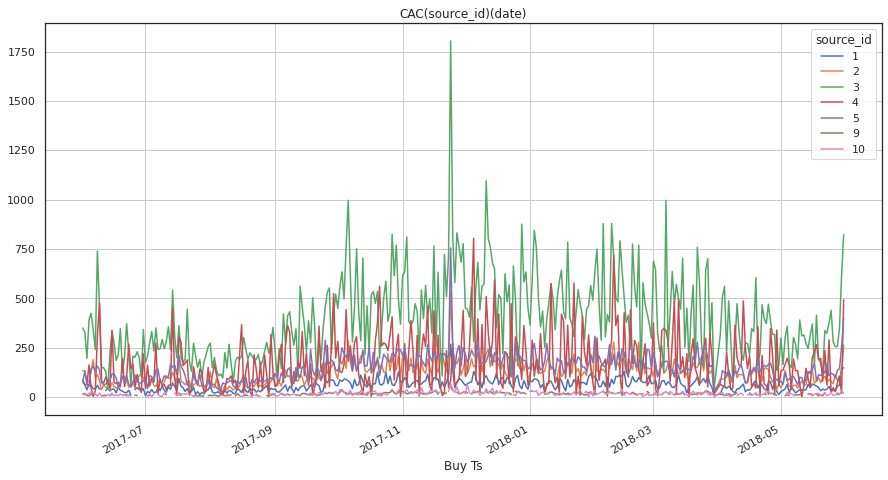

source_id,1,2,3,4,5,9,10
count,361.000000,362.000000,363.000000,363.000000,363.000000,280.000000,313.000000
mean,59.849781,122.207878,393.785393,170.663003,148.408138,16.168574,17.079203
std,29.335371,56.738675,212.471641,139.010288,67.364320,6.996969,9.939355
min,5.800000,15.080000,39.260000,0.830000,34.000000,3.450000,0.540000
25%,37.630000,79.410000,229.230000,60.215000,99.163500,10.847500,9.860000
50%,57.140000,119.675000,355.820000,130.820000,145.821176,15.725000,16.110000
75%,78.500000,152.047500,505.585000,258.935000,186.415000,20.862500,21.940000
max,266.869141,525.200357,1804.686239,804.447292,755.181000,49.530000,68.110000


In [137]:
shaolin_graf(dfff, 'CAC(source_id)(date)')


как видим- лучший канал привлечения - 10, худший -3. Тенденция у всех каналов похожа

Опять видимм магическую дату 24.11.2017. Но, в данном случае инвистиции в рекламу дали наименьший выхлоп

#### 2.3.3) ROMI <a name="ROMI "></a> 


Рассчитаем ROMI: поделим LTV на CAC.

работать будем с уже подготовленной ранее таблицей:


In [138]:
df_CAC.sample(3)

,Uid,source_id,costs,Buy Ts,Revenue
16457,10994889860435314754,3,184.98,2018-04-20,1.65
34810,5288404146709286666,10,26.68,2017-06-05,2.44
15192,9100728935102567127,3,544.27,2018-01-24,7.33


для удобства счёта- модифицируем формулу ROMI:

 ROMI = LTV / CAC , где:

 LTV = Sum(Revenue за период) / n(когрты)

 CAC = costs / n(когрты)

 путём нехитрых сокращений получаем:

 **ROMI (определённой когорты за определённый период) = Sum(Revenue за период) / costs**  

т.к. нас больше интересует экономика продаж, а не экоомика узнаваемости, то в данном случае посчитаем когорты на основании первых дат продаж (а не посещений)

напишем функцию, которая на вход будет получать начальную дату и кол-во месяцев жизни когорт для расчёта. В теле функции будем преобразовывать данные в когорты по источникам прихода (но, т.к. затраты на источники одни и теже в разные даты - то по сути будем преобразовывать в когорты по дням), после чего будем считать ROMI для каждой когорты 

Так же, будем считать что клиента привлекает только первая реклама. Если он при следующей попытке сделал переход по другой ссылке- то мы всё равно его отнесём к предыдущей когорте (т.е. расходы на привлечение возьмём из первого перехода)

Ещё учтём, что источник рекламы может быть один (например рекламное агентство "конвертик и копыта" (т.е. source_id - один), а рекламные компании были разные (везде разная сумма), т.е. будем делить эти рекламные акции

для удобства, напишем дату первой покупки для каждого покупателя вотдельный  столбец:

In [139]:
#df_CAC.groupby('Uid')['Buy Ts'].min().reset_index().rename(columns = {'Buy Ts' : 'first_buy_ts'})
df_CAC = df_CAC.merge( df_CAC.groupby('Uid')['Buy Ts'].min().reset_index().rename(columns = {'Buy Ts' : 'first_buy_ts'})  , on = 'Uid')


In [140]:
df_CAC.sample(4)

,Uid,source_id,costs,Buy Ts,Revenue,first_buy_ts
19142,14505618534593938893,3,451.91,2018-04-10,1.95,2018-04-10
12921,4549684674837969482,3,203.70,2017-07-18,1.59,2017-07-18
20535,1474474809470440929,5,88.50,2017-08-21,1.34,2017-07-14
20892,12852047649282210746,5,61.24,2017-08-15,4.89,2017-08-15


In [141]:
print('последняя дата предоставленных данных:',df_CAC['Buy Ts'].max() )

последняя дата предоставленных данных: 2018-05-31 00:00:00


In [142]:
def ROMI_cohort_month(start_date, quantity_month ):
  if quantity_month < 1:
    return 'ошибка в ведённых параметрах'
  # отсеим ненужные даты:
  start_date = pd.to_datetime(start_date)
  last_date = start_date + np.timedelta64(quantity_month, 'M')  

  if df_CAC['Buy Ts'].max() < last_date:
    return 'нет подходящих данных или ошибка в ведённых параметрах'

  larg_date =pd.to_datetime('2018-05-31')  -  np.timedelta64(quantity_month, 'M') 
  df_ROMI = df_CAC[ (df_CAC['Buy Ts'] >= start_date) &  (df_CAC['first_buy_ts'] <= larg_date )   ] #выбираем подходящие строки  

  ROMI_rab_table = df_ROMI.groupby(['first_buy_ts' , 'source_id']).agg({'Revenue' : 'sum', 'costs' : 'first'}).reset_index()
  ROMI_rab_table['ROMI'] = round(ROMI_rab_table['Revenue'] / ROMI_rab_table['costs'] , 2)
  ROMI_rab_table_pivot = ROMI_rab_table.pivot_table(index = 'first_buy_ts', columns = 'source_id',values = 'ROMI')
  return ROMI_rab_table_pivot
 
  

In [143]:
ROMI_cohort_month('2017-06-08', 8)

source_id,1,2,3,4,5,9,10
first_buy_ts,,,,,,,
2017-06-01,3.48,1.90,0.09,0.45,3.54,0.07,0.04
2017-06-02,1.53,0.47,0.00,0.16,0.76,NaN,NaN
2017-06-03,1.50,0.77,0.05,0.05,0.86,NaN,NaN
2017-06-04,0.05,0.01,NaN,NaN,NaN,NaN,NaN
2017-06-05,9.23,1.48,0.06,1.15,3.54,0.14,NaN
...,...,...,...,...,...,...,...
2017-09-25,1.74,0.63,0.46,1.64,0.41,0.04,0.17
2017-09-26,1.26,0.29,1.31,0.34,0.44,0.12,NaN
2017-09-27,0.46,0.35,0.52,2.26,0.56,0.55,0.10


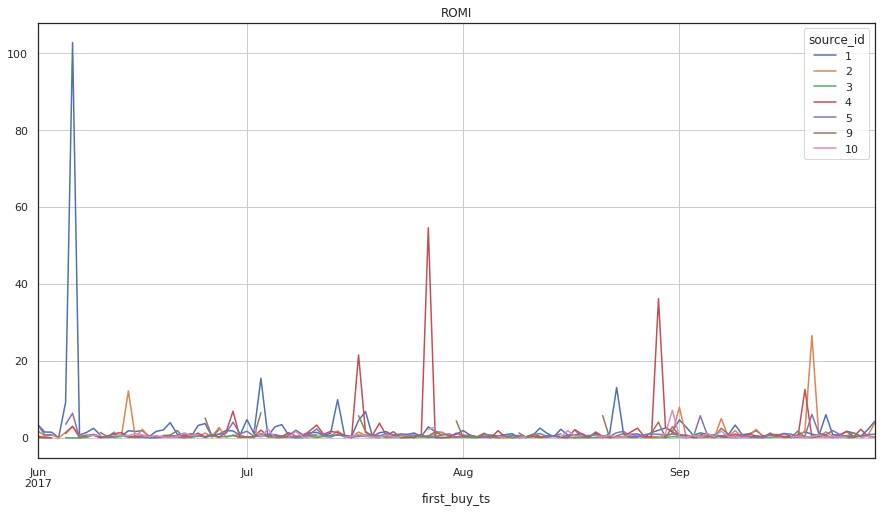

source_id,1,2,3,4,5,9,10
count,120.000000,120.000000,120.000000,120.000000,120.000000,92.000000,86.000000
mean,2.623417,1.002083,0.260000,1.794417,0.867333,0.935543,0.635930
std,9.499152,2.773602,0.226749,6.288057,1.038375,1.356662,0.929076
min,0.040000,0.010000,0.000000,0.050000,0.020000,0.000000,0.010000
25%,0.677500,0.200000,0.120000,0.225000,0.400000,0.147500,0.162500
50%,1.085000,0.405000,0.210000,0.470000,0.645000,0.450000,0.330000
75%,1.897500,0.692500,0.312500,1.112500,0.870000,1.055000,0.745000
max,102.750000,26.620000,1.310000,54.640000,6.410000,6.560000,7.200000


In [144]:
shaolin_graf(ROMI_cohort_month('2017-06-08', 8), 'ROMI')


как видим из графика- бывали очень удачные маркетинговые акции, были и не очень успешные

согласно таблице по анализу данных (идёт сразу после графика), среднее значение источника 1 - 2,623 - довольно успешный канал вливания маркетинговых средств. В свою очередь, канал 3 (среднее =  0,26) - не очень успешен для данной платформы

#Вывод <a name="conclusion"></a>



при измерении метрик обнаружилась дата 2017-11-24 , в которую все метрики вели себя очень необычно. Стоит обратить внимание на все процессы, происходившие в этот день! Нужны доп данные!


### 3.1) лучшие источники трафика <a name="trafic_winner"></a> 




В конечном смысле - любое предприятие создаётся для извлечения дохода (как не звучит парадоксально- даже государевы конторы направленные только на расходование средств для улучшения всего и вся, в конечном итоге являются частью звена, приносящего прибыль государству или гражданам).

 Соответственно, с точки зрения предприятия- маркетинговые затраты (в нашем случае это точки увеличения посещения платформы поетителями с деньгами и желанием купить) должны приносить прибыль (а иначе зачем они нужны?).

 Посмотрим на график метрики ROMI - это наш фаворит в данном вопросе. И он расчитывается для определённого кол-ва месяцев. Например, возьмём 8 месяцев:

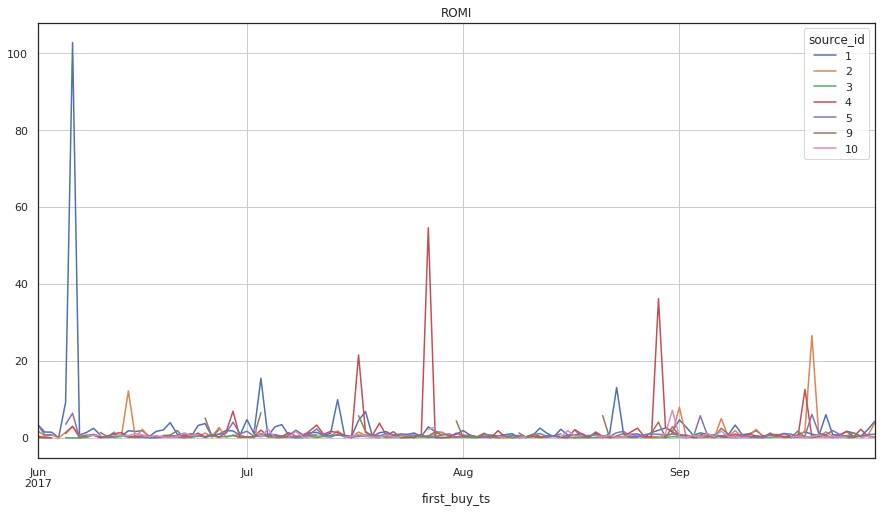

source_id,1,2,3,4,5,9,10
count,120.000000,120.000000,120.000000,120.000000,120.000000,92.000000,86.000000
mean,2.623417,1.002083,0.260000,1.794417,0.867333,0.935543,0.635930
std,9.499152,2.773602,0.226749,6.288057,1.038375,1.356662,0.929076
min,0.040000,0.010000,0.000000,0.050000,0.020000,0.000000,0.010000
25%,0.677500,0.200000,0.120000,0.225000,0.400000,0.147500,0.162500
50%,1.085000,0.405000,0.210000,0.470000,0.645000,0.450000,0.330000
75%,1.897500,0.692500,0.312500,1.112500,0.870000,1.055000,0.745000
max,102.750000,26.620000,1.310000,54.640000,6.410000,6.560000,7.200000


In [145]:
shaolin_graf(ROMI_cohort_month('2017-06-08', 8), 'ROMI')

несомненные лидеры - это источники трафика "1" и "4" (смотрим на среднее значение за весь период "mean"). Источник трафика "2" находится на грани окупаемости. Остальные источники унесли денег больше, чем смогли привлечь. 

**НО!!!!**! у разных источников были и успешные компании (параметр "max" таблицы).  Так же, у КАЖДОГО источника были откровенно провальные компании (параметр "min"). Надо разбираться какие именно компании были проведены в эти дни и анализировать сопутствующие факторы. Для этого нужно запрашивать дополнительные данные.

### 3.2) выводы по каждым метрикам <a name="metric_conclusion"></a> 


Маркетинговые метрики:

Кажды источник доолнительных клиентов работает по разному. В среднем, есть откровенно убыточные, есть и прибыльные. НО у каждого истоника были прибыльные и убыточные компании. Получили расчёт метрики ROMI которая поможет найти успешные маркетинговые ходы и сделать упор на их развитии


Продуктовые метрики:

Получили метрику успешности (узнаваемости) платформы- 900 уникальных пользователей в день и 23 000 в месяц заходили на платформу (не факт, что делали покупку- поэтому и "узнаваемость"). Мало это или много надо сравнивать с конкурентами. В среднем пользователи не заходят второй раз в день на платформу- соответственно надо размещать те продукты, которые планируют покупать с первого раза. Среднее время на сайте - 5 минут. Надо продавать услуги, которые возможно выбрать за короткое время, или пользователь должен уже целенаправлено идти на платформу за заранее выбранной услугой. Renetation Rate показал что не большая доля покупателей возвращается, но те кто вернулся- станут преданными поклонниками платформы.

Метрики электронной коммерции:

Пользователи, в среднем, делают покупку через 17 дней после первого захода на платформу (ознакомления). Так же, увидели, что метрика, отслеживающая среднее кол-во покупок на одного покупателя за определённый период с увеличением периода- увеличивается. Возьмём во внимание что данная метрика считалась только для активных пользователей (т.е. те пользователи, которые в отчётном периоде возвращались на платформу в ознакомительных целях). Т.е. мы посчитали эту метрику для преданных фанатов платформы (см. предыдущий абзац). И онна не может нас не радовать. Средний чек по всем покупателям- 5,33. В общем он стабилен, но бывают всплески (вероятно, какие-то культовые события). Средняя накопительная доходность от пользователя- 8,1 единиц

### 3.3) итоги когортного анализа <a name="cohort_analiz"></a> 


Принимая во внимание тот момент, что компания должна извлекать прибыль- рассмотрим когорты со стороны прибыльности: 

В абсолютном выражении нам интересна метрика "LTV" - накопительная прибыльность когорты - самая "прибыльная" когорта - люди, пивлечёные в сентябре 2017 года. Остальные когорты примерно равны. Не стоит упускать из виду, что данная метрика считается за период, и на других периодах она может изменяться.

В относительном выражении нам интересна метрика "ROMI" учитывающая не только прибыльность клента, но и затраты на его привлечение. Но учитывая, что клиент уже привлечён (деньги потрачены), то будем "дожимать" клиента до полного и пользоваться абсолютной метрикой